# Laod data and prepare it
This simple example demonstrates how to plug TensorFlow Datasets (TFDS) into a Keras model.


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import math
import time
from tqdm import trange

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("training dataset:", len(x_train))
print("test dataset:", len(x_test))

training dataset: 60000
test dataset: 10000


5


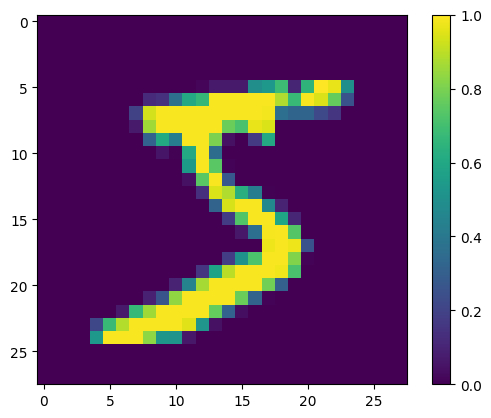

In [ ]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [ ]:
# Importation de la fonction shift du module scipy.ndimage.interpolation
from scipy.ndimage.interpolation import shift

# Définition d'une méthode pour déplacer une image selon les dimensions spécifiées
def shift_image(image, dx, dy):
    # Remodelage de l'image en une matrice de dimensions 28x28
    image = image.reshape((28, 28))

    # Appel de la fonction shift pour déplacer l'image selon les paramètres dx et dy
    # cval spécifie la valeur à utiliser pour remplir les zones nouvellement créées
    # mode spécifie le mode de remplissage pour les zones nouvellement créées (constant dans ce cas)
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")

    # Retourne l'image déplacée
    return shifted_image


<ipython-input-5-a394babc2174>:2: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


In [ ]:
# Importation du module NumPy
import numpy as np

# Création d'un tableau de 100 éléments, initialisés à 1
idxs = np.ones(100)

# Boucle parcourant les chiffres de 0 à 9
for digit in range(10):
    # Trouver les indices des occurrences du chiffre dans y_train
    digit_args = np.argwhere(y_train == digit)[:10, 0]

    # Mélanger aléatoirement les indices obtenus
    np.random.shuffle(digit_args)

    # Assigner les indices mélangés aux emplacements appropriés dans idxs
    idxs[digit * 10:(digit + 1) * 10] = digit_args

# Mélanger aléatoirement l'ensemble des indices dans idxs
np.random.shuffle(idxs)

# Convertir idxs en une liste d'entiers
idxs = list(idxs.astype("int"))


In [ ]:
# Sélection des données d'entraînement étiquetées en utilisant les indices mélangés
x_train_labeled = x_train[idxs]
y_train_labeled = y_train[idxs]

# Suppression des données d'entraînement étiquetées des données d'entraînement originales
x_train_unlabeled_original = np.delete(x_train.copy(), idxs, axis=0)

# Sélection de la moitié des données d'entraînement non étiquetées originales
x_train_unlabeled = x_train_unlabeled_original[:int(x_train_unlabeled_original.shape[0] / 2)]

# Création d'un jeu de données augmenté en appliquant une translation aux images non étiquetées sélectionnées
x_train_augmented = []
for image in x_train_unlabeled:
    # Ajout de la version déplacée de l'image à la liste augmentée
    x_train_augmented.append(np.expand_dims(shift_image(image, 3, 3), axis=-1))

# Conversion de la liste augmentée en un tableau NumPy
x_train_augmented = np.array(x_train_augmented)


## Seperate the unlabeled images into original and augmeneted images

In [ ]:
# Initialisation d'un dictionnaire pour stocker les indices associés à chaque chiffre
digit_idxs = {}

# Boucle parcourant les chiffres de 0 à 9
for digit in range(10):
    # Trouver les indices des occurrences du chiffre dans y_train
    digit_args = np.argwhere(y_train == digit)[:, 0]

    # Mélanger aléatoirement les indices obtenus
    np.random.shuffle(digit_args)

    # Stocker les indices mélangés dans le dictionnaire digit_idxs
    digit_idxs[digit] = list(digit_args.astype('int'))


In [ ]:
# Calcul du nombre minimal d'éléments par classe, en prenant la moitié du nombre minimum d'indices parmi toutes les classes
elt_per_class = int(min([len(idxs) for idxs in digit_idxs.values()]) / 2)

# Affichage du nombre d'éléments par classe
elt_per_class

2710

In [ ]:
# Initialisation de deux dictionnaires pour stocker les données et les étiquettes associées à chaque chiffre
digit_data = {}
digit_label = {}

# Boucle parcourant les chiffres uniques dans y_train
for digit in np.unique(y_train):
    # Séparation des indices pour obtenir deux groupes d'indices par classe
    indices_1 = digit_idxs[digit][:elt_per_class]
    indices_2 = digit_idxs[digit][elt_per_class:elt_per_class * 2]

    # Stockage des données associées à chaque chiffre dans digit_data
    digit_data[digit] = (x_train[indices_1], x_train[indices_2])

    # Stockage des étiquettes associées à chaque chiffre dans digit_label
    digit_label[digit] = (y_train[indices_1], y_train[indices_2])


In [ ]:
# Initialisation des variables original_data et original_labels
original_data = None
original_labels = None

# Boucle parcourant les chiffres uniques dans y_train
for digit in np.unique(y_train):
    # Si c'est la première itération, assigner les données et les étiquettes correspondantes
    if original_data is None:
        original_data = digit_data[digit][0]
        original_labels = digit_label[digit][0]
    else:
        # Pour les itérations suivantes, concaténer les données et les étiquettes aux valeurs existantes
        original_data = np.concatenate((original_data, digit_data[digit][0]))
        original_labels = np.concatenate((original_labels, digit_label[digit][0]))


In [ ]:
# Initialisation des variables augmented_data et augmented_labels
augmented_data = None
augmented_labels = None

# Boucle parcourant les chiffres uniques dans y_train
for digit in np.unique(y_train):
    # Si c'est la première itération, assigner les données augmentées et les étiquettes correspondantes
    if augmented_data is None:
        augmented_data = digit_data[digit][1]
        augmented_labels = digit_label[digit][1]
    else:
        # Pour les itérations suivantes, concaténer les données augmentées et les étiquettes aux valeurs existantes
        augmented_data = np.concatenate((augmented_data, digit_data[digit][1]))
        augmented_labels = np.concatenate((augmented_labels, digit_label[digit][1]))


In [ ]:
# Génération d'une permutation aléatoire des indices pour réorganiser les données
permutation = np.random.permutation(original_data.shape[0])

# Application de la permutation aux données et étiquettes originales et augmentées
augmented_data, original_data, augmented_labels, original_labels = augmented_data[permutation], \
original_data[permutation], augmented_labels[permutation], original_labels[permutation]


In [ ]:
# Comparaison élément par élément des étiquettes augmentées et originales
comparison_result = np.equal(augmented_labels, original_labels)

# Recherche des valeurs uniques dans le tableau de comparaisons
unique_values = np.unique(comparison_result)


In [ ]:
augmented_data.shape

(27100, 28, 28, 1)

In [ ]:
original_data.shape

(27100, 28, 28, 1)

9


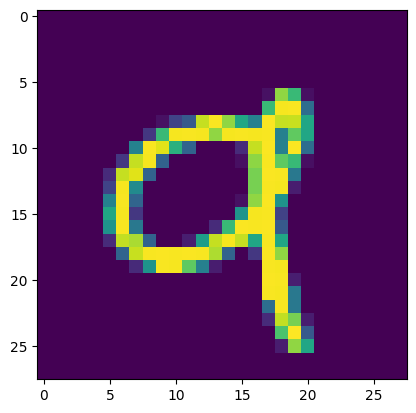

In [ ]:
print(augmented_labels[0])

plt.imshow(augmented_data[0, :, :, 0])


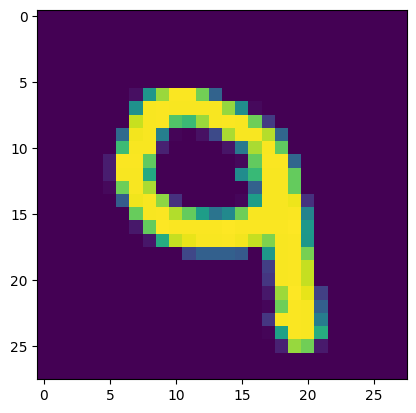

In [ ]:
plt.imshow(original_data[0, :, :, 0])


# Baseline

In [ ]:
# Définition de la forme de l'entrée du modèle, qui est une image de 28x28 pixels
inputs = keras.Input(shape=(28, 28), name="digits")

# Couche Dense avec 128 neurones et une fonction d'activation ReLU
x1 = keras.layers.Dense(128, activation="relu")(inputs)

# Couche de sortie Dense avec 10 neurones (un pour chaque classe de chiffre)
outputs = keras.layers.Dense(10, name="predictions")(x1)

# Création du modèle en spécifiant les entrées et les sorties
model = keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
# Création d'un modèle séquentiel en spécifiant les couches dans l'ordre
model = keras.Sequential([
    # Couche Flatten pour convertir une image 28x28 en un vecteur unidimensionnel de taille 784
    tf.keras.layers.Flatten(input_shape=(28, 28)),

    # Couche Dense avec 128 neurones et une fonction d'activation ReLU
    tf.keras.layers.Dense(128, activation='relu'),

    # Couche Dense de sortie avec 10 neurones correspondant aux classes de chiffres
    tf.keras.layers.Dense(10, name="classifier")
])


In [ ]:
# Initialisation de l'optimiseur Adam
optimizer = keras.optimizers.Adam()

# Initialisation de la fonction de perte SparseCategoricalCrossentropy
# from_logits=True indique que les sorties du modèle sont non normalisées (logits)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Initialisation de la métrique d'exactitude pour l'entraînement
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Initialisation de la métrique d'exactitude pour la validation
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Définition de la taille du lot (batch size) pour l'entraînement
batch_size = 128

In [ ]:
labels_per_batch=10
unlabels_per_batch=59
all_x = None
for i in range(int(100/labels_per_batch)):
    # Si c'est la première itération, concaténer les données étiquetées, non étiquetées et augmentées
    if all_x is None:
        all_x = np.concatenate((x_train_labeled[i*labels_per_batch:i*labels_per_batch+labels_per_batch], x_train_unlabeled[i*unlabels_per_batch : i*unlabels_per_batch+unlabels_per_batch], x_train_augmented[i*unlabels_per_batch: i*unlabels_per_batch+unlabels_per_batch]))
    # Pour les itérations suivantes, concaténer les données aux valeurs existantes dans all_x
    else:
        all_x = np.concatenate((all_x,x_train_labeled[i*labels_per_batch:i*labels_per_batch+labels_per_batch], x_train_unlabeled[i*unlabels_per_batch : i*unlabels_per_batch+unlabels_per_batch], x_train_augmented[i*unlabels_per_batch: i*unlabels_per_batch+unlabels_per_batch]))

In [ ]:
all_x.shape

(1280, 28, 28, 1)

In [ ]:
# Décoration de la fonction avec @tf.function pour la convertir en un graphe TensorFlow
@tf.function
def test_step(x, y):
    # Évaluation des logits du modèle sur les données de test
    val_logits = model(x, training=False)

    # Mise à jour de la métrique d'exactitude pour les données de test
    val_acc_metric.update_state(y, val_logits)


In [ ]:
# Création d'un ensemble de données à partir des données de test et de leurs étiquettes
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Division de l'ensemble de données en lots (batch) de taille 64
val_dataset = val_dataset.batch(64)


In [ ]:
import math

# Nombre d'époques
epochs = 10

# Boucle sur les époques
for epoch in range(epochs):
    print("\nDébut de l'époque %d" % (epoch,))

    # Itérer sur les lots (batches) de l'ensemble de données combiné (all_x)
    for step in range(math.ceil(all_x.shape[0] / batch_size)):
        # Extraire le lot d'images et d'étiquettes étiquetées
        x_batch_train = all_x[step * batch_size:step * batch_size + labels_per_batch]
        y_batch_train = y_train_labeled[step * labels_per_batch:step * labels_per_batch + labels_per_batch]

        # Ouvrir une GradientTape pour enregistrer les opérations effectuées
        # pendant la passe avant, ce qui permet l'autodifférenciation.
        with tf.GradientTape() as tape:
            # Exécuter la passe avant du modèle sur le lot.
            # Les opérations appliquées aux entrées du modèle
            # seront enregistrées sur la GradientTape.
            logits = model(x_batch_train, training=True)  # Logits pour ce lot
            # Calcul de la valeur de perte pour ce lot.
            loss_value = loss_fn(y_batch_train, logits[:labels_per_batch])

        # Utiliser la bande de gradient pour récupérer automatiquement
        # les gradients des variables entraînables par rapport à la perte.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Exécuter une étape de descente de gradient en mettant à jour
        # la valeur des variables pour minimiser la perte.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Mettre à jour la métrique d'entraînement.
        train_acc_metric.update_state(y_batch_train, logits[:labels_per_batch])

        # Afficher les métriques toutes les 200 lots.
        if step % 200 == 0:
            print(
                "Perte d'entraînement (pour un lot) à l'étape %d: %.4f"
                % (step, float(loss_value))
            )
            print("Échantillons vus jusqu'à présent : %s" % ((step + 1) * batch_size))

    # Afficher les métriques à la fin de chaque époque.
    train_acc = train_acc_metric.result()
    print("Exactitude d'entraînement sur l'époque : %.4f" % (float(train_acc),))

    # Réinitialiser les métriques d'entraînement à la fin de chaque époque.
    train_acc_metric.reset_states()



Début de l'époque 0
Perte d'entraînement (pour un lot) à l'étape 0: 0.0125
Échantillons vus jusqu'à présent : 128
Exactitude d'entraînement sur l'époque : 1.0000

Début de l'époque 1
Perte d'entraînement (pour un lot) à l'étape 0: 0.0118
Échantillons vus jusqu'à présent : 128
Exactitude d'entraînement sur l'époque : 1.0000

Début de l'époque 2
Perte d'entraînement (pour un lot) à l'étape 0: 0.0111
Échantillons vus jusqu'à présent : 128
Exactitude d'entraînement sur l'époque : 1.0000

Début de l'époque 3
Perte d'entraînement (pour un lot) à l'étape 0: 0.0104
Échantillons vus jusqu'à présent : 128
Exactitude d'entraînement sur l'époque : 1.0000

Début de l'époque 4
Perte d'entraînement (pour un lot) à l'étape 0: 0.0098
Échantillons vus jusqu'à présent : 128
Exactitude d'entraînement sur l'époque : 1.0000

Début de l'époque 5
Perte d'entraînement (pour un lot) à l'étape 0: 0.0093
Échantillons vus jusqu'à présent : 128
Exactitude d'entraînement sur l'époque : 1.0000

Début de l'époque 6
P

In [ ]:
# Itérer sur les lots de l'ensemble de données de validation
for x_batch_val, y_batch_val in val_dataset:
    # Exécuter la passe avant du modèle sur le lot de validation.
    val_logits = model(x_batch_val, training=False)

    # Mettre à jour les métriques de validation
    val_acc_metric.update_state(y_batch_val, val_logits)

# Calculer et afficher l'exactitude de validation à la fin de l'évaluation
val_acc = val_acc_metric.result()
val_acc_metric.reset_states()
print("Exactitude de validation : %.4f" % (float(val_acc),))


Exactitude de validation : 0.7063


# UDA Implementation

In [ ]:
def _kl_divergence_with_logits(p_logits, q_logits):
    # Calcul des distributions de probabilités à partir des logits
    p = tf.nn.softmax(p_logits)        # Distribution de probabilité pour p
    log_p = tf.nn.log_softmax(p_logits) # Logarithme de la softmax de p
    log_q = tf.nn.log_softmax(q_logits) # Logarithme de la softmax de q

    # Calcul de la divergence de Kullback-Leibler
    kl = tf.reduce_sum(p * (log_p - log_q), -1)

    return kl

In [ ]:
def get_ent(logits, return_mean=True):
    # Calcul du logarithme de la softmax des logits
    log_prob = tf.nn.log_softmax(logits, axis=-1)

    # Calcul de la probabilité à partir du logarithme de la softmax
    prob = tf.exp(log_prob)

    # Calcul de l'entropie
    ent = tf.reduce_sum(-prob * log_prob, axis=-1)

    # Si return_mean est True, calculer la moyenne de l'entropie
    if return_mean:
        ent = tf.reduce_mean(ent)

    return ent


In [ ]:
def get_tsa_threshold(schedule, global_step, num_train_steps, start, end):
    # Calcul du ratio de l'étape globale par rapport au nombre total d'étapes d'entraînement
    step_ratio = float(global_step) / float(num_train_steps)

    # Sélection du calendrier (schedule) spécifié
    if schedule == "linear_schedule":
        # Calendrier linéaire
        coeff = step_ratio
    elif schedule == "exp_schedule":
        # Calendrier exponentiel avec échelle 5
        scale = 5
        # [exp(-5), exp(0)] = [1e-2, 1]
        coeff = tf.exp((step_ratio - 1) * scale)
    elif schedule == "log_schedule":
        # Calendrier logarithmique avec échelle 5
        scale = 5
        # [1 - exp(0), 1 - exp(-5)] = [0, 0.99]
        coeff = 1 - tf.exp((-step_ratio) * scale)

    # Calcul du seuil en fonction du calendrier spécifié
    return coeff * (end - start) + start


In [ ]:
def anneal_sup_loss(sup_logits, sup_labels, sup_loss, global_step, nbr_steps, num_classes, tsa_schedule):
    # Définir le début du seuil TSA en fonction du nombre de classes
    tsa_start = 1. / num_classes

    # Obtenir le seuil effectif en utilisant la fonction get_tsa_threshold
    eff_train_prob_threshold = get_tsa_threshold(
        tsa_schedule, global_step, nbr_steps,
        tsa_start, end=1)

    # Convertir les étiquettes en one-hot encoding
    one_hot_labels = tf.one_hot(
        sup_labels, depth=num_classes, dtype=tf.float32)

    # Calculer les probabilités de softmax pour les logits supervisés
    sup_probs = tf.nn.softmax(sup_logits, axis=-1)

    # Calculer les probabilités des étiquettes correctes
    correct_label_probs = tf.reduce_sum(
        one_hot_labels * sup_probs, axis=-1)

    # Comparer les probabilités correctes avec le seuil effectif
    larger_than_threshold = tf.greater(
        correct_label_probs, eff_train_prob_threshold)

    # Créer un masque de perte en fonction de la comparaison
    loss_mask = 1 - tf.cast(larger_than_threshold, tf.float32)
    loss_mask = tf.stop_gradient(loss_mask)

    # Appliquer le masque à la perte supervisée
    sup_loss = sup_loss * loss_mask

    # Calculer la perte supervisée moyenne en tenant compte du masque
    avg_sup_loss = (tf.reduce_sum(sup_loss) /
                    tf.maximum(tf.reduce_sum(loss_mask), 1))

    return sup_loss, avg_sup_loss


In [ ]:
import keras
import copy

def create_train(hyper, epochs=10, pretraining=False, verbose=False):

    # Copie profonde des hyperparamètres pour éviter les modifications indésirables
    hyper = copy.deepcopy(hyper)

    # Définition de l'architecture du modèle
    model = keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(hyper["l2"]),
                              # kernel_initializer=keras.initializers.he_normal
                             ),
        tf.keras.layers.Dropout(hyper["dropout"]),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(hyper["l2"]),
                              # kernel_initializer=keras.initializers.he_normal
                             ),
        tf.keras.layers.Dropout(hyper["dropout"]),
        tf.keras.layers.Dense(10, name="classifier")
    ])

    # Configuration des hyperparamètres pour l'entraînement
    hyper["optimizer"] = keras.optimizers.Adam()
    hyper["loss_fn"] = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    hyper["train_acc_metric"] = keras.metrics.SparseCategoricalAccuracy()
    hyper["val_acc_metric"] = keras.metrics.SparseCategoricalAccuracy()

    # Création de l'ensemble de données de validation
    val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    val_dataset = val_dataset.batch(128)

    # Entraînement préalable si spécifié
    if pretraining:
        print("Démarrage de l'entraînement préalable")
        pretrain(model, x_train_labeled, y_train_labeled, val_dataset, epochs)

    # Entraînement principal
    print("Démarrage de l'entraînement")
    train(model, x_train_labeled, original_data, augmented_data, val_dataset, hyper, epochs, verbose=verbose)


In [ ]:
def pretrain(model, x_train, y_train, val_dataset, epochs=10, verbose=False):
    # Configuration de l'optimiseur, de la fonction de perte, et des métriques
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    # Entraînement du modèle sur les données étiquetées
    model.fit(
        x_train, y_train,
        epochs=epochs,
        validation_data=val_dataset,
        verbose=0  # Utiliser verbose=1 pour afficher des détails d'entraînement pendant les époques
    )

    # Évaluation et affichage de la précision sur l'ensemble de validation après l'entraînement préalable
    val_accuracy = model.evaluate(val_dataset, batch_size=128)[1]
    print("Précision de validation après l'entraînement préalable: %.4f \n\n" % val_accuracy)


In [ ]:
def train(model,x_train_labeled,original_data,augmented_data,val_dataset, hyper, epochs=10, verbose=False):

    @tf.function
    def test_step(x, y):
        val_logits = model(x, training=False)
        val_acc_metric.update_state(y, val_logits)

    unlabels_per_batch = hyper["unlabels_per_batch"]
    batch_unique_labels = hyper["batch_unique_labels"]
    labels_per_batch = hyper["labels_per_batch"]
    hyper["labels_per_batch"]

    optimizer = hyper["optimizer"]
    loss_fn = hyper["loss_fn"]
    train_acc_metric = hyper["train_acc_metric"]
    val_acc_metric = hyper["val_acc_metric"]
    tsa_schedule = hyper["tsa_schedule"]
    num_classes = hyper["num_classes"]
    uda_softmax_temp = hyper["uda_softmax_temp"]
    uda_confidence_thresh = hyper["uda_confidence_thresh"]
    ent_min_coeff = hyper["ent_min_coeff"]
    lamd = hyper["lamd"]
    # Boucle principale sur les époques
    for epoch in trange(epochs):
        if(verbose):
            print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()

        # Itération sur les lots du jeu de données
        for step in range(int(original_data.shape[0]/unlabels_per_batch)):
            # Séparation des différents types d'images : supervisées, originales non étiquetées, augmentées non étiquetées
            sup_images = x_train_labeled[int(step % batch_unique_labels)*labels_per_batch:int(step % batch_unique_labels)*labels_per_batch+labels_per_batch]
            ori_images = original_data[step*unlabels_per_batch: step*unlabels_per_batch+unlabels_per_batch]
            aug_images = augmented_data[step*unlabels_per_batch: step*unlabels_per_batch+unlabels_per_batch]

            # Concaténation pour former le lot d'entraînement
            x_batch_train = np.concatenate((sup_images, ori_images, aug_images))
            y_batch_train = y_train_labeled[int(step % batch_unique_labels)*labels_per_batch:int(step % batch_unique_labels)*labels_per_batch+labels_per_batch]

            # Utilisation de GradientTape pour enregistrer les opérations pendant la passe avant
            with tf.GradientTape() as tape:
                # Passe avant pour obtenir les logits
                logits = model(x_batch_train, training=True)
                # Extraction des logits pour les exemples supervisés
                sup_logits = logits[:labels_per_batch]
                # Calcul de la perte supervisée
                sup_loss = loss_fn(y_batch_train, sup_logits)

                # Utilisation de la perte TSA si spécifiée
                if tsa_schedule:
                    sup_loss, avg_sup_loss = anneal_sup_loss(sup_logits, y_batch_train, sup_loss, epoch, epochs, num_classes, tsa_schedule)
                else:
                    avg_sup_loss = tf.reduce_mean(sup_loss)
                total_loss = avg_sup_loss

                # Calcul de la perte à partir des données non étiquetées

                # Logits des images non étiquetées réelles
                ori_logits = logits[labels_per_batch: labels_per_batch + unlabels_per_batch]
                # Logits des images non étiquetées augmentées
                aug_logits = logits[labels_per_batch + unlabels_per_batch:]

                # Ajustement des prédictions avec un softmax tempéré si spécifié
                if uda_softmax_temp != -1:
                    ori_logits_tgt = ori_logits / uda_softmax_temp
                else:
                    ori_logits_tgt = ori_logits

                # calcul de KL divergence
                aug_loss = _kl_divergence_with_logits(
                    p_logits=tf.stop_gradient(ori_logits_tgt),
                    q_logits=aug_logits)

                if uda_confidence_thresh != -1:
                    ori_prob = tf.nn.softmax(ori_logits, axis=-1)
                    largest_prob = tf.reduce_max(ori_prob, axis=-1)
                    loss_mask = tf.cast(tf.greater(
                        largest_prob, uda_confidence_thresh), tf.float32)
                    loss_mask = tf.stop_gradient(loss_mask)
                    aug_loss = aug_loss * loss_mask

                if ent_min_coeff > 0:
                    per_example_ent = get_ent(ori_logits)
                    ent_min_loss = tf.reduce_mean(per_example_ent)
                    total_loss = total_loss + ent_min_coeff * ent_min_loss

                avg_unsup_loss = tf.reduce_mean(aug_loss)

                total_loss += lamd * avg_unsup_loss


            # Utilisation de GradientTape pour récupérer automatiquement
            # les gradients des variables entraînables par rapport à la perte
            grads = tape.gradient(total_loss, model.trainable_weights)

            # Exécution d'une étape de descente de gradient en mettant à jour
            # les valeurs des variables pour minimiser la perte
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            # Mise à jour de la métrique d'entraînement
            train_acc_metric.update_state(y_batch_train, logits[:labels_per_batch])

            if verbose:
                if step % 50 == 0:
                    print(
                        "Training loss (for one batch) at step %d: %.4f"
                        % (step, float(total_loss))
                    )
                    print("Seen so far: %s samples" % ((step + 1) * batch_size))

        # Affichages des métriques à chaque fin d'itération
        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        train_acc_metric.reset_states()

        for x_batch_val, y_batch_val in val_dataset:
            test_step(x_batch_val, y_batch_val)

        val_acc = val_acc_metric.result()
        val_acc_metric.reset_states()
        print("Validation acc: %.4f" % (float(val_acc),))
        if verbose:
            print("Time taken: %.2fs \n" % (time.time() - start_time))
    return float(val_acc)

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(128)

In [ ]:
labels_per_batch = 50
batch_size = 128

hyper = {
    "labels_per_batch":labels_per_batch,
    "batch_size" : batch_size,
    "batch_unique_labels":100/labels_per_batch,
    "unlabels_per_batch":int((batch_size-labels_per_batch)/2),
    "nbr_batch" : 100,
    "lamd" : 1,
    "tsa_schedule":"exp_schedule",
    # tsa_schedule=""
    "num_classes" : 10,
    "uda_softmax_temp" : 0.9,
    "uda_confidence_thresh" : 0.8,
    "ent_min_coeff" : 0.5,

    "num_classes" : 10,
    "decay_steps" : 1000,
    "moving_average_decay":0.9999,
    "initial_learning_rate":1e-2,
    "dropout":0.8,
    "l2": 0.1
}

In [ ]:
create_train(hyper, epochs=10, pretraining=False, verbose=False)

Démarrage de l'entraînement


  0%|          | 0/10 [00:00<?, ?it/s]

Training acc over epoch: 0.6930


 10%|█         | 1/10 [00:35<05:15, 35.06s/it]

Validation acc: 0.7486
Training acc over epoch: 0.9131


 20%|██        | 2/10 [01:08<04:33, 34.24s/it]

Validation acc: 0.7794
Training acc over epoch: 0.9338


 30%|███       | 3/10 [01:43<04:01, 34.51s/it]

Validation acc: 0.7877
Training acc over epoch: 0.9454


 40%|████      | 4/10 [02:18<03:28, 34.70s/it]

Validation acc: 0.7878
Training acc over epoch: 0.9498


 50%|█████     | 5/10 [02:53<02:53, 34.74s/it]

Validation acc: 0.8111
Training acc over epoch: 0.9567


 60%|██████    | 6/10 [03:28<02:19, 34.93s/it]

Validation acc: 0.8339
Training acc over epoch: 0.9625


 70%|███████   | 7/10 [04:03<01:44, 34.77s/it]

Validation acc: 0.8321
Training acc over epoch: 0.9661


 80%|████████  | 8/10 [04:37<01:09, 34.60s/it]

Validation acc: 0.8339
Training acc over epoch: 0.9716


 90%|█████████ | 9/10 [05:11<00:34, 34.31s/it]

Validation acc: 0.8411
Training acc over epoch: 0.9728


100%|██████████| 10/10 [05:45<00:00, 34.59s/it]

Validation acc: 0.8404
